<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_05_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.05 Wave Net

* 날짜:
* 이름:

## 학습내용
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts')
from lib import *

In [ ]:
'''lib.py
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
'''

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



### **| kaggle 데이터 연동**


1. kaggle 로그인 - my account - API Create New Api Token - `kaggle.json` 파일 다운로드
2. Drive에 저장해 놓는것을 권장
3. kaggle 패키지 다운로드
```
! pip install kaggle
```
4. 권한 변경
```
! chmod 600 `드라이브 파일 경로`
```
5. `~/` 위치에 복사
```
! cp `드라이브 파일 경로` ~/.kaggle/kaggle.json
```

6. 데이터셋 다운로드
```
! kaggle datasets download 데이터주소
```

In [3]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
#! chmod 600 /content/drive/MyDrive/scripts/kaggle.json

In [6]:
! mkdir ~/.kaggle/

In [7]:
! cp /content/drive/MyDrive/scripts/kaggle.json ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.21G/1.21G [00:14<00:00, 137MB/s]
100% 1.21G/1.21G [00:14<00:00, 88.0MB/s]


In [ ]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

### **| EDA**

In [10]:
df = pd.read_csv('/content/Data/features_30_sec.csv')
print(df.shape)
df.head()

(1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


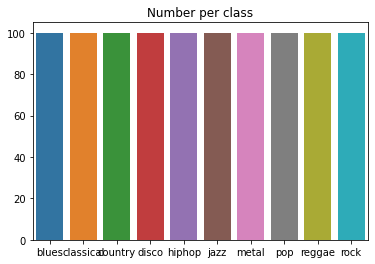

In [13]:
# 예측해야할 클래스
class_count = df['label'].value_counts()
plt.title('Number per class')
_=sns.barplot(x=class_count.index , y=class_count.values)

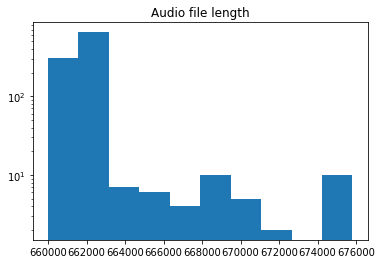

In [15]:
# 음성 파일의 길이
plt.title('Audio file length')
_=plt.hist(df['length'], log=True)

특성 개수 57


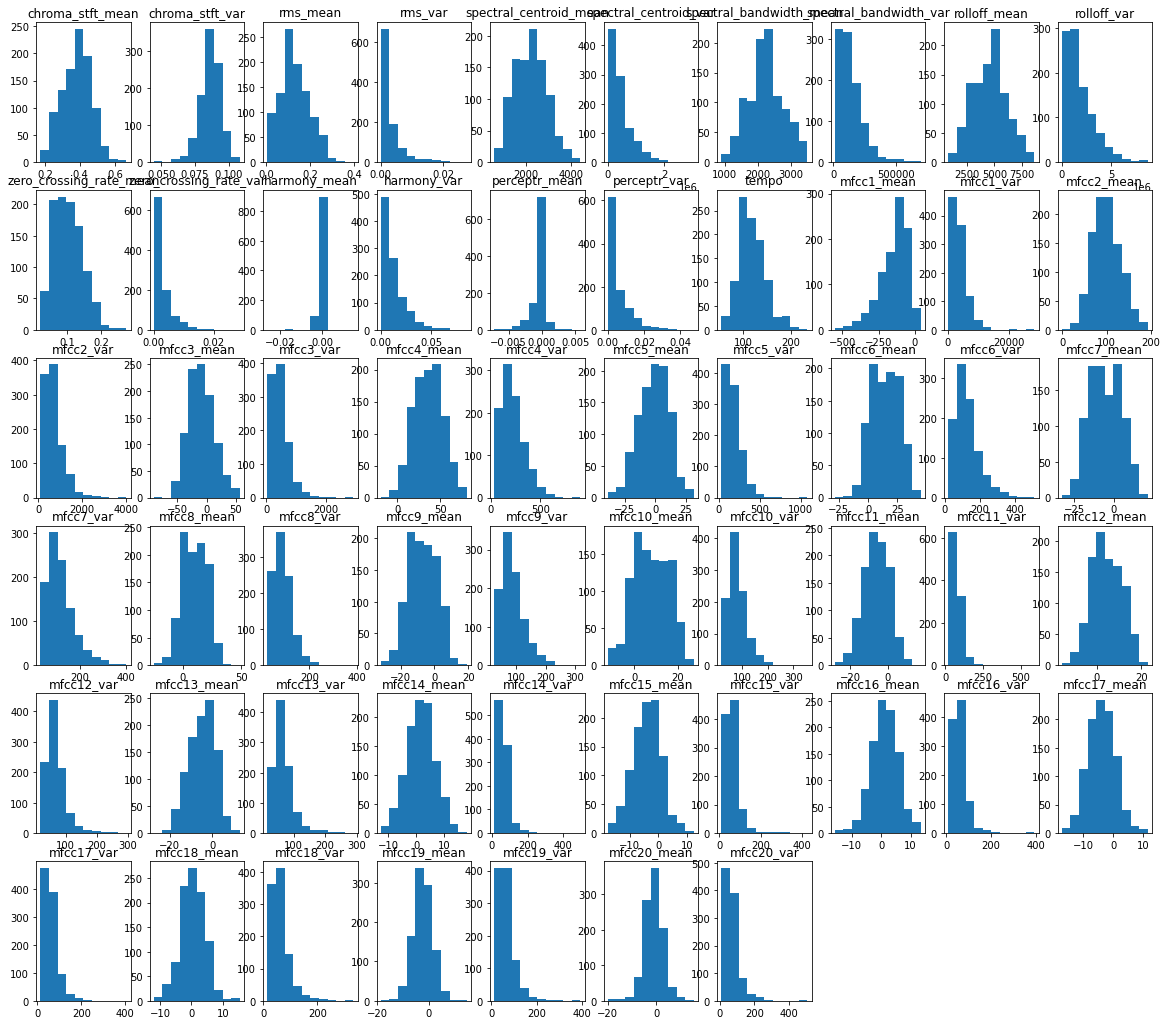

In [22]:
# 특성 분포 
print('특성 개수', len(df.columns[2:-1]))
plt.figure(figsize=(20,18))
for i, col in enumerate(df.columns[2:-1]):
  plt.subplot(6,10, i+1)
  plt.title(col)
  plt.hist(df[col])

## 머신러닝 접근 방법 (features)
---

### **| 파라미터 추가**


### **| 전처리**


In [25]:
# label encoding ( blues, classical, ... ) - > (0, 1, ...)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,le_label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,0
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,0
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,0
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,0
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,0


In [26]:
x = df.drop(columns=['filename', 'length', 'label', 'le_label'])
y = df['le_label']
x.shape, y.shape

((1000, 57), (1000,))

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (900, 57) (900,)
test (100, 57) (100,)


In [29]:
# x 정규화
sc = preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape

((900, 57), (100, 57))

### **| 학습 - XGBoost**

In [30]:
! pip install xgboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 40 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [32]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Test Acc: 0.79


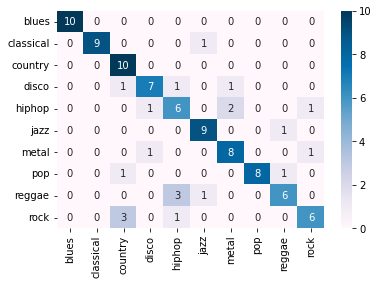

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def show_result(model, x_test, y_test):
  y_pred = model.predict(x_test)
  print('Test Acc:', accuracy_score(y_test, y_pred))
  #print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  _=sns.heatmap(cm, annot=True, cmap='PuBu', xticklabels=le.classes_, yticklabels=le.classes_)
show_result(xgb, x_test, y_test)

### **| 학습 - DNN**

In [ ]:
# 딥러닝 (Dense layer)


## 딥러닝 접근 방법(Audio 원 데이터)
---